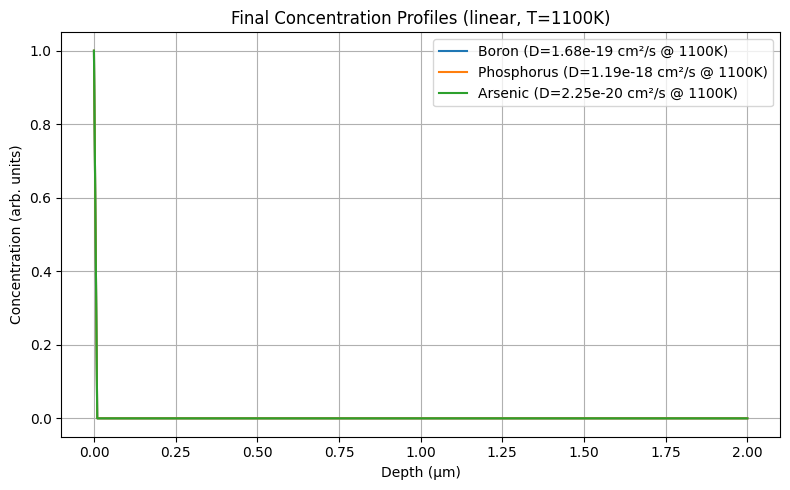

Running joint optimization (time, temp)...
Optimization finished in 0.2 s
Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 1e-06
        x: [ 1.000e+00  1.100e+03]
      nit: 0
      jac: [ 0.000e+00  0.000e+00]
     nfev: 3
     njev: 1
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

Optimal diffusion time for Boron: 1.0000 h (3600.0 s)
Optimal diffusion temperature for Boron: 1100.00 K
Objective target error: 1.000e-06


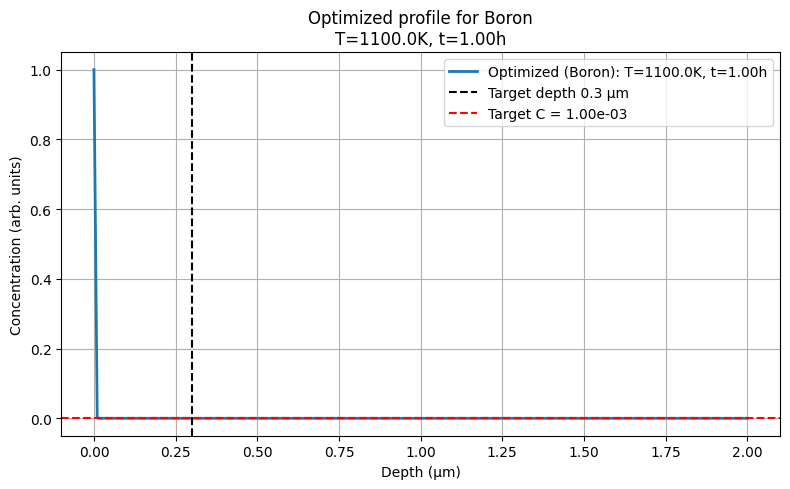


Comparing all dopants with joint (t, T) optimization...
Boron: t = 1.0000h, T = 1100.0K, error=1.000e-06
Phosphorus: t = 0.5000h, T = 1150.0K, error=1.000e-06
Arsenic: t = 0.1000h, T = 1250.0K, error=1.000e-06

Dopant	Optimal hours	Optimal T(K)	Error
Boron	1.0000	1100.00	1.00e-06
Phosphorus	0.5000	1150.00	1.00e-06
Arsenic	0.1000	1250.00	1.00e-06


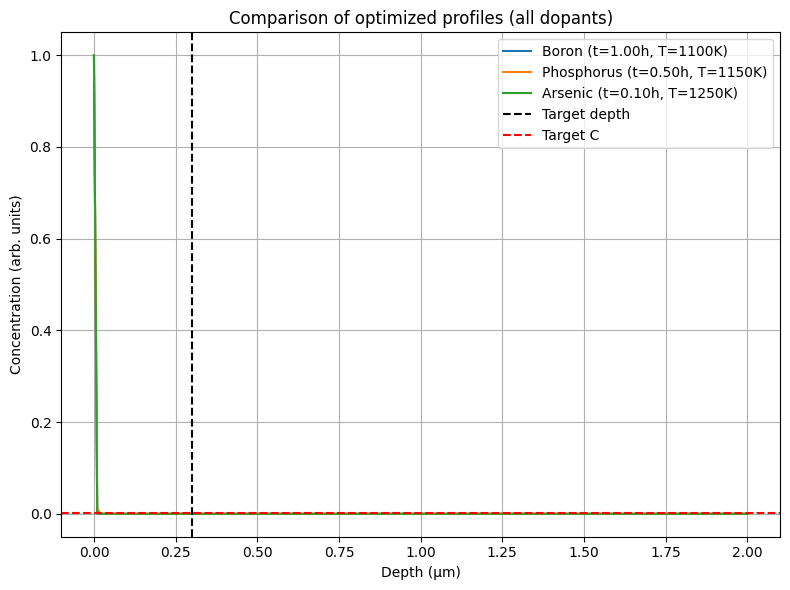

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.optimize import minimize
import time as _time

# ----------------------------
# CRANK-NICOLSON SOLVER (Corrected)
# ----------------------------
def crank_nicolson_constantD(D, L, Nx, dt, Nt, C_left=1.0, C_right=0.0, save_fraction=10):
    dx = L / (Nx - 1)
    alpha = D * dt / (2 * dx**2)
    x = np.linspace(0, L, Nx)
    C = np.zeros(Nx)
    C[0] = C_left
    C[-1] = C_right

    n_in = Nx - 2
    if n_in <= 0:
        raise ValueError("Nx must be >= 3")

    main_A = (1 + 2*alpha) * np.ones(n_in)
    off_A  = -alpha * np.ones(n_in - 1)
    A = diags([off_A, main_A, off_A], offsets=[-1, 0, 1], format='csc')

    main_B = (1 - 2*alpha) * np.ones(n_in)
    off_B  = alpha * np.ones(n_in - 1)
    B = diags([off_B, main_B, off_B], offsets=[-1, 0, 1], format='csc')

    snapshots = []
    times = []
    save_interval = max(1, Nt // save_fraction)

    for n in range(Nt):
        rhs = B.dot(C[1:-1])
        rhs[0] += alpha * (C[0] + C_left)
        rhs[-1] += alpha * (C[-1] + C_right)
        
        C_inner = spsolve(A, rhs)
        C[1:-1] = C_inner

        if (n % save_interval == 0) or (n == Nt-1):
            snapshots.append(C.copy())
            times.append((n+1) * dt)
    return x, np.array(times), snapshots

# ----------------------------
# DOPANT PARAMETERS (D0, Ea)
# ----------------------------
dopant_params = {
    "Boron":      {"D0": 1.2e-3, "Ea": 3.46},      # D0 in cm²/s, Ea in eV
    "Phosphorus": {"D0": 7.0e-2, "Ea": 3.66},
    "Arsenic":    {"D0": 1.0e-1, "Ea": 4.07},
}
kB = 8.617e-5  # Boltzmann constant in eV/K

def D_of_T(dopant, T_K):
    """Diffusion coefficient D (cm^2/s) for dopant and temperature T in K."""
    p = dopant_params[dopant]
    return p['D0'] * np.exp(-p['Ea'] / (kB * T_K))

# ----------------------------
# SIM SETTINGS
# ----------------------------
L    = 2e-4    # wafer thickness (cm)
Nx   = 200
dt   = 0.1     # will be re-set per optimization
Nt   = 2000    # will be re-set per optimization

PLOT_BASIC    = True
PLOT_EXTRA    = True
RUN_OPTIMIZE  = True

# ----------------------------
# BASIC PLOTS (using default D at 1100K for illustration)
# ----------------------------
if PLOT_BASIC:
    plt.figure(figsize=(8,5))
    for dopant in dopant_params.keys():
        D = D_of_T(dopant, 1100)
        x, times, snapshots = crank_nicolson_constantD(D, L, Nx, dt, Nt)
        final = snapshots[-1]
        plt.plot(x*1e4, final, label=f"{dopant} (D={D:.2e} cm²/s @ 1100K)")
    plt.xlabel("Depth (µm)")
    plt.ylabel("Concentration (arb. units)")
    plt.title("Final Concentration Profiles (linear, T=1100K)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ----------------------------
# JOINT TIME-TEMP OPTIMIZATION (SINGLE DOPANT)
# ----------------------------
if RUN_OPTIMIZE:
    dopant_to_opt = "Boron"
    x_target_um = 0.3
    x_target_cm = x_target_um * 1e-4
    C_target = 1e-3
    Nt_opt_max = 500

    def objective_joint(params):
        time_hours, T_K = params
        if not (0.01 <= time_hours <= 10.0 and 700 <= T_K <= 1400):
            return 1e12
        t_total_s = time_hours * 3600.0
        D = D_of_T(dopant_to_opt, T_K)
        dt_opt = t_total_s / Nt_opt_max
        try:
            x, times, snapshots = crank_nicolson_constantD(D, L, Nx, dt_opt, Nt_opt_max)
        except:
            return 1e12
        C_final = snapshots[-1]
        idx = np.argmin(np.abs(x - x_target_cm))
        return float((C_final[idx] - C_target)**2)

    x0 = [1.0, 1100.0]
    bounds = [(0.01, 10.0), (700, 1400)]

    print("Running joint optimization (time, temp)...")
    t_start = _time.time()
    res_joint = minimize(objective_joint, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-8, 'maxfun':100})
    t_end = _time.time()
    print(f"Optimization finished in {t_end - t_start:.1f} s")
    print("Result:", res_joint)

    if res_joint.success:
        optimal_hours, optimal_TK = res_joint.x
        print(f"\nOptimal diffusion time for {dopant_to_opt}: {optimal_hours:.4f} h ({optimal_hours*3600:.1f} s)")
        print(f"Optimal diffusion temperature for {dopant_to_opt}: {optimal_TK:.2f} K")
        print(f"Objective target error: {res_joint.fun:.3e}")

        t_total_s = optimal_hours * 3600.0
        D_opt = D_of_T(dopant_to_opt, optimal_TK)
        dt_high = t_total_s / Nt_opt_max
        x, times, snapshots = crank_nicolson_constantD(D_opt, L, Nx, dt_high, Nt_opt_max)
        C_opt = snapshots[-1]

        plt.figure(figsize=(8,5))
        plt.plot(x*1e4, C_opt, linewidth=2, label=f"Optimized ({dopant_to_opt}): T={optimal_TK:.1f}K, t={optimal_hours:.2f}h")
        plt.axvline(x_target_um, color='k', linestyle='--', label=f"Target depth {x_target_um} µm")
        plt.axhline(C_target, color='r', linestyle='--', label=f"Target C = {C_target:.2e}")
        plt.xlabel('Depth (µm)')
        plt.ylabel('Concentration (arb. units)')
        plt.title(f'Optimized profile for {dopant_to_opt}\nT={optimal_TK:.1f}K, t={optimal_hours:.2f}h')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Joint (time, temp) optimization did not converge.")

# ----------------------------
# OPTIONAL: EXTENDED Multi-Dopant Joint Optimization/Comparison
# ----------------------------
if RUN_OPTIMIZE:
    print("\nComparing all dopants with joint (t, T) optimization...")
    optimized_results = {}

    for dopant in dopant_params.keys():
        
        # New: Use a dopant-specific initial guess
        if dopant == "Boron":
            x0_dopant = [1.0, 1100.0]
        elif dopant == "Phosphorus":
            x0_dopant = [0.5, 1150.0]
        elif dopant == "Arsenic":
            x0_dopant = [0.1, 1250.0]
            
        def obj_joint(params):
            time_hours, T_K = params
            if not (0.01 <= time_hours <= 10.0 and 700 <= T_K <= 1400):
                return 1e12
            t_total_s = time_hours * 3600.0
            D = D_of_T(dopant, T_K)
            dt_opt = t_total_s / Nt_opt_max
            try:
                x_c, times_c, snaps_c = crank_nicolson_constantD(D, L, Nx, dt_opt, Nt_opt_max)
            except Exception:
                return 1e12
            C_final = snaps_c[-1]
            idx = np.argmin(np.abs(x_c - x_target_cm))
            return float((C_final[idx] - C_target)**2)

        res = minimize(obj_joint, x0_dopant, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-8, 'maxfun':100})
        optimized_results[dopant] = {'res': res}
        
        if res.success:
            opt_hours, opt_TK = res.x
            optimized_results[dopant]['opt_hours'] = opt_hours
            optimized_results[dopant]['opt_TK'] = opt_TK
            optimized_results[dopant]['opt_error'] = res.fun
            print(f"{dopant}: t = {opt_hours:.4f}h, T = {opt_TK:.1f}K, error={res.fun:.3e}")
            t_total_s = opt_hours * 3600.0
            D = D_of_T(dopant, opt_TK)
            dt_opt = t_total_s / Nt_opt_max
            x, times, snaps = crank_nicolson_constantD(D, L, Nx, dt_opt, Nt_opt_max)
            C_final = snaps[-1]
            optimized_results[dopant]['x'] = x
            optimized_results[dopant]['C_opt'] = C_final
        else:
            print(f"{dopant} optimization failed.")

    print('\nDopant\tOptimal hours\tOptimal T(K)\tError')
    for dopant in optimized_results.keys():
        info = optimized_results[dopant]
        if 'opt_hours' in info:
            print(f"{dopant}\t{info['opt_hours']:.4f}\t{info['opt_TK']:.2f}\t{info['opt_error']:.2e}")
        else:
            print(f"{dopant}\tFAILED")
            
    plt.figure(figsize=(8,6))
    for dopant, info in optimized_results.items():
        if 'C_opt' in info:
            plt.plot(info['x']*1e4, info['C_opt'], label=f"{dopant} (t={info['opt_hours']:.2f}h, T={info['opt_TK']:.0f}K)")
    plt.axvline(x_target_um, color='k', linestyle='--', label='Target depth')
    plt.axhline(C_target, color='r', linestyle='--', label='Target C')
    plt.xlabel('Depth (µm)')
    plt.ylabel('Concentration (arb. units)')
    plt.title('Comparison of optimized profiles (all dopants)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()